<a id="data_exploration"></a>
# 1. Data Exploration

The dataset is available in the */data* folder. The database structure is freely inspired from the AP-HP Clinical Data Warehouse (CDW).

Let's assume that data were extracted from the CDW on **December 1st, 2025**.

# Exercise 1: a first illustration of Real-World Data (RWD) analysis

In this first exercise we introduce some basic categories of RWD and we illustrate some of the challenges related to their preprocessing for research.

We initialize the notebook by importing the following libraries:

In [1]:
import pandas as pd
import numpy as np

# Visualization library
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

# For the computation of Kaplan-Meier estimates and log-rank tests
import lifelines

# Table of content

1. [Data Exploration](#data_exploration)  
    1.1 [Patients' identities and demographic data](#patient_ids)  
    1.2 [Administrative data related to patients' pathways](#visits)  
    1.3 [Claim data related to patients' conditions (diagnosis)](#cond)  
    1.4 [Structured medication data](#med)  
2. [Preprocessing](#preprocessing)  
    2.1 [First attempt of visualizing survival curves](#first_kaplan)  
    2.2 [Pre-processing patients' identities and demographic data](#prepro_patient)  
    2.3 [Pre-processing administrative data related to patients' pathways](#prepro_visits)  
    2.4 [Pre-processing claim data](#prepro_cond)  
3. [Statistical analysis](#stat)  
    3.1 [First objective : Are the drugs efficient on the overall population ?](#stat_first_kaplan)  
    3.2 [Second objective : Sub-population analysis](#stat_second_kaplan)  
4. [Takeaways](#takeaways) 
5. [References](#references)  

<a id="data_exploration"></a>
# 1. Data Exploration

The dataset is available in the */data* folder. The database structure is freely inspired from the AP-HP Clinical Data Warehouse (CDW).

Let's assume that data were extracted from the CDW on **December 1st, 2025**.

<a id="patient_ids"></a>
## 1.1 Patients' identities and demographic data

- Open the *data/df_person.pkl* file using the `pandas.read_pickle()` function.
- Explore the type of each feature of the `df_person` DataFrame with the `.info()` function.
- Check out the first rows of the DataFrame using the `.head()` function.

In [15]:
df_person = pd.read_pickle('data/df_person.pkl')
df_person.info()
df_person.head()

<class 'pandas.core.frame.DataFrame'>
Index: 57000 entries, 0 to 1749
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   person_id            57000 non-null  int64         
 1   birth_datetime       51249 non-null  datetime64[ns]
 2   death_datetime       26194 non-null  datetime64[ns]
 3   gender_source_value  57000 non-null  object        
 4   cdm_source           57000 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 2.6+ MB


,person_id,birth_datetime,death_datetime,gender_source_value,cdm_source
0,85902261,2012-04-06,2025-10-14,f,EHR 1
1,80206244,2014-05-09,NaT,f,EHR 1
2,83994765,2006-08-22,NaT,f,EHR 1
3,89192524,2018-09-18,NaT,f,EHR 1
4,81459188,2014-08-20,NaT,f,EHR 1


How many patient_ids do we have in this database ?

TIP : You can use the `DataFrame.col_name.unique()` function on one of the columns

In [9]:
print(f"We have {df_person["person_id"].nunique()} unique patient ids in this dataset.")

We have 57000 unique patient ids in this dataset.


<a id="visits"></a>
## 1.2 Administrative data related to patients' pathways

Explore the `df_visit` DataFrame that gathers administrative data about patient's hospitalizations.

In [16]:
df_visit = pd.read_pickle('data/df_visit.pkl')
df_visit.info()
df_visit.head()

<class 'pandas.core.frame.DataFrame'>
Index: 57000 entries, 0 to 1749
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   visit_occurrence_id   57000 non-null  int64         
 1   care_site_id          57000 non-null  object        
 2   visit_start_datetime  57000 non-null  datetime64[ns]
 3   visit_end_datetime    56599 non-null  datetime64[ns]
 4   person_id             57000 non-null  int64         
 5   visit_source_value    57000 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 3.0+ MB


,visit_occurrence_id,care_site_id,visit_start_datetime,visit_end_datetime,person_id,visit_source_value
0,87039763,Hopital M.Bres,2024-12-24,2025-01-10,85935943,Hospitalisés
1,83184379,Centre F.Sinoussi,2025-09-01,2025-09-21,87104656,Hospitalisés
2,87368296,Hopital M.Bres,2023-01-08,2023-01-08,80785788,Hospitalisés
3,84290710,Hopital M.Bres,2024-11-27,2024-12-13,82815332,Hospitalisés
4,87357364,Centre F.Sinoussi,2025-07-29,2025-08-07,80509718,Hospitalisés


Compute the number of visits recorded by care site.

TIP : You can use the `DataFrame.col_name.value_counts()`function on the right column

In [12]:
df_visit.groupby('care_site_id')['visit_occurrence_id'].nunique().reset_index()

,care_site_id,visit_occurrence_id
0,Centre F.Sinoussi,14147
1,Clinique L.Pasteur,14349
2,GHU A.Fleming,14390
3,Hopital M.Bres,14114


<a id="cond"></a>
## 1.3 Claim data related to patients' conditions (diagnosis)

Explore the `df_condition` DataFrame that gathers claim data used by hospital managers for reimbursement purposes.

Meeting with experts has allowed us to identify the ICD-10 codes corresponding to the flu virus :
- J09
- J10
- J11

You can check out on the following website the meaning of those codes : https://www.aideaucodage.fr/cim

In [14]:
df_condition = pd.read_pickle('data/df_condition.pkl')
df_condition.info()
df_condition.head()

<class 'pandas.core.frame.DataFrame'>
Index: 57000 entries, 0 to 1749
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   visit_occurrence_id      57000 non-null  int64 
 1   person_id                57000 non-null  int64 
 2   condition_occurrence_id  57000 non-null  int64 
 3   condition_source_value   57000 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.2+ MB


,visit_occurrence_id,person_id,condition_occurrence_id,condition_source_value
0,87039763,85935943,86006023,J10
1,83184379,87104656,87765316,J11
2,87368296,80785788,89665004,J09
3,84290710,82815332,84026043,J10
4,87357364,80509718,86346709,J10


How many ICD-10 codes can you identify in this dataset ?  

TIP : You can use the `DataFrame.col_name.unique()` function.

In [20]:
print(f"The available ICD-10 codes are the following : {df_condition["condition_source_value"].unique()}")

The available ICD-10 codes are the following : ['J10' 'J11' 'J09' 'B019' 'V9544' 'U0715']


<a id="med"></a>
## 1.4 Structured medication data

Explore the `df_med` DataFrame gathering structured data in regards to medication administration during hospital stays.

In [21]:
df_med = pd.read_pickle('data/df_med.pkl')
df_med.info()
df_med.head()

<class 'pandas.core.frame.DataFrame'>
Index: 38000 entries, 0 to 3499
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   visit_occurrence_id  38000 non-null  object
 1   drug_exposure_id     38000 non-null  object
 2   drug_source_value    38000 non-null  object
 3   cdm_source           38000 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


,visit_occurrence_id,drug_exposure_id,drug_source_value,cdm_source
0,83508825,81635492,drugA,EHR med
1,84793089,81981242,drugA,EHR med
2,81363581,81049850,drugA,EHR med
3,84194047,89471075,drugA,EHR med
4,86390630,88647388,drugA,EHR med


<a id="preprocessing"></a>
# 2. Preprocessing

Now that we know what categories of data are available, let's process them!

We have defined two helper functions in the *viz.py* script that leverage the [*lifelines*](https://lifelines.readthedocs.io/en/latest/) library to plot Kaplan-Meier estimates and compute log-rank tests relatively to our objectives :  
1. Evaluate the overall impact of drug A and B
2. Stratify our analysis on age and gender

In [23]:
#Import the helper functions
import sys
sys.path.append("../")
sys.path.append("data/")
from viz import plot_primary_kaplan, plot_secondary_kaplan

<a id="first_kaplan"></a>
## 2.1 First attempt of visualizing survival curves

Let's try to compute straightforwardly the Kaplan-Meier estimates!  

First define the end date of the study, as needed to censor data, using the [*datetime*](https://pypi.org/project/DateTime/) package.

In [25]:
end_of_study = datetime.date(2025,12,1)

Print the docstrings of the `plot_primary_kaplan` function, and use them to plot the first Kaplan-Meier estimates for the whole population regarding the drug administration.

TIP : To print the documentation of a function, you can call the `__doc__`attribute of the function.

In [24]:
print(plot_primary_kaplan.__doc__)


Function that displays survival curves computed by the KaplanMeierFitter function from the lifeline package. 
It compares the drugA and drugB effects to the control cohort.

Parameters
----------
:param df_person_kaplan: pandas df,
    DataFrame gathering the demographic data about the patients of interest.
    Must have the same structure as the initial `df_person` table (must contain especially `person_id`
    and potential `death_datetime`).
:param list_case: list of tuples,
    List of studied case for the survival analysis.
    List of tuple (df_visit-pandas df-, df_med-pandas df-, name-str-) having :
        - df_visit : hospitalization DataFrame, with information on entry/exit dates
        - df_med : drug administration DataFrame, must contain ONLY the drugs of interest (i.e epidemic)
        - name : name of the studied case (for visualization purposes)
:param t_end_of_study: datetime.date,
    Date of the end of the study, i.e after which no information can be trusted (censo

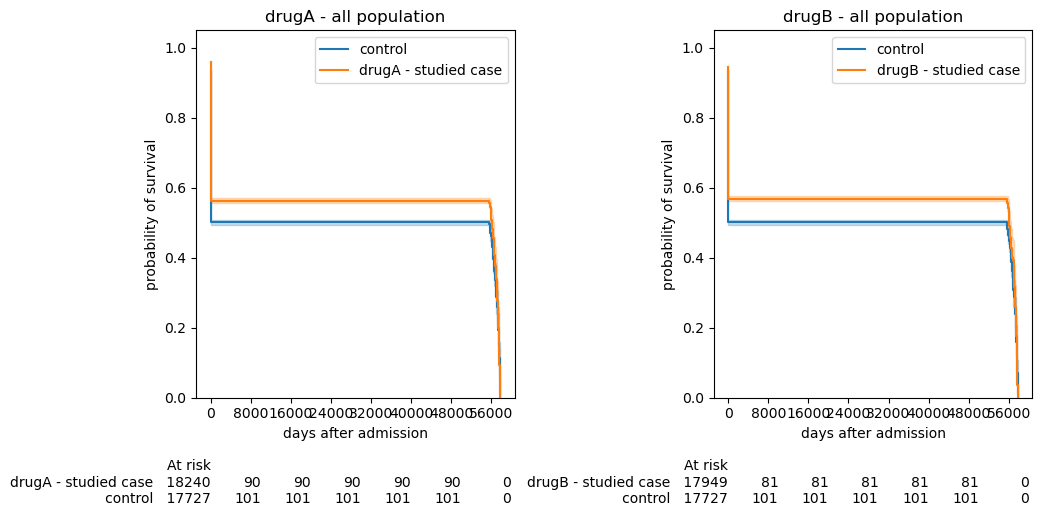

In [26]:
plot_primary_kaplan(df_person_kaplan=df_person, list_case=[(df_visit,df_med,"studied case")], t_end_of_study=end_of_study)

Does the Kaplan-Meier estimates seem correct ?

<a id="prepro_patient"></a>
## 2.2 Pre-processing patients' identities and demographic data

### 2.2.1 Birth dates

Let's explore identities and demographic data. Count the number of missing values for each feature of the `df_person` DataFrame. What do you observe ?

TIP : Use the `DataFrame.isna().sum()` function to compute the number of NA values within each column of the DataFrame.

In [29]:
df_person.head()

,person_id,birth_datetime,death_datetime,gender_source_value,cdm_source
0,85902261,2012-04-06,2025-10-14,f,EHR 1
1,80206244,2014-05-09,NaT,f,EHR 1
2,83994765,2006-08-22,NaT,f,EHR 1
3,89192524,2018-09-18,NaT,f,EHR 1
4,81459188,2014-08-20,NaT,f,EHR 1


In [30]:
df_med.head()

,visit_occurrence_id,drug_exposure_id,drug_source_value,cdm_source
0,83508825,81635492,drugA,EHR med
1,84793089,81981242,drugA,EHR med
2,81363581,81049850,drugA,EHR med
3,84194047,89471075,drugA,EHR med
4,86390630,88647388,drugA,EHR med


In [31]:
df_condition.head()

,visit_occurrence_id,person_id,condition_occurrence_id,condition_source_value
0,87039763,85935943,86006023,J10
1,83184379,87104656,87765316,J11
2,87368296,80785788,89665004,J09
3,84290710,82815332,84026043,J10
4,87357364,80509718,86346709,J10


In [28]:
df_visit.head()

,visit_occurrence_id,care_site_id,visit_start_datetime,visit_end_datetime,person_id,visit_source_value
0,87039763,Hopital M.Bres,2024-12-24,2025-01-10,85935943,Hospitalisés
1,83184379,Centre F.Sinoussi,2025-09-01,2025-09-21,87104656,Hospitalisés
2,87368296,Hopital M.Bres,2023-01-08,2023-01-08,80785788,Hospitalisés
3,84290710,Hopital M.Bres,2024-11-27,2024-12-13,82815332,Hospitalisés
4,87357364,Centre F.Sinoussi,2025-07-29,2025-08-07,80509718,Hospitalisés


In [27]:
df_person.isna().sum()

person_id                  0
birth_datetime          5751
death_datetime         30806
gender_source_value        0
cdm_source                 0
dtype: int64

Some dates of birth are missing. Can you search for the origin of this lack of data ?

TIP : Check out the impact of `cdm_source` in the missingness of birth datetime.

In [35]:
cross_tab = pd.crosstab(df_person['birth_datetime'].apply(lambda x: 'Oui' if pd.notnull(x) else 'Non'), df_person['cdm_source'], margins=True, margins_name="Total")
cross_tab

cdm_source,EHR 1,EHR 2,Total
birth_datetime,,,
Non,0,5751,5751
Oui,51249,0,51249
Total,51249,5751,57000


In [36]:
print(f"Number of missing birth datetimes for EHR 1 : {df_person[df_person['cdm_source'] == 'EHR 1']['birth_datetime'].isna().sum()}")

NameError: name 'df' is not defined

In [ ]:
print(f"Number of missing birth datetimes for EHR 2 : {df_person[df_person['cdm_source'] == 'EHR 2']['birth_datetime'].isna().sum()}")

What would you suggest to address this bias ?

**Correction** :  
The birth dates quality issue can be directly associated to the registration within the "EHR 2" software. Although it could include a clinical bias, a solution may be to discard data coming from this software (this assumption should be grounded in an understanding of the context of use of both softwares! Clinicians' expertise shall be leveraged to confirm/infirm this assumption).

Create a `df_person_fix` DataFrame that contains patient information coming from `cdm_source` other than "EHR 2".

TIP : 
You can use the `query` built-in function : 
```python 
df_condition.query("content of your query")

In [ ]:
df_person_fix = #TODO
df_person_fix.info()

Now that we have handled the missingness of dates of birth, let's check the plausibility of the available dates. Plot the birth datetime distribution as a bar chart.

Tip 1 : you can convert the birth datetime to a "YYYY-MM" format using the following command : 
```python 
    df_person_fix['birth_date'] = df_person_fix['birth_datetime'].dt.strftime('%Y-%m')
```  
Tip 2 : If your DataFrame contains too many rows, you can use the `pandas.DataFrame.groupby()` function and count the number of `person_id` by `birth_date`.

In [ ]:
df_person_fix['birth_date'] = #TODO

In [ ]:
birth_dates_summary = #TODO

In [ ]:
#TODO

What do you see ? Does this distribution look normal ?

### 2.2.2 Death dates

Plot the death datetime distribution. Do you observe anything seeming abnormal ?

TIP : Use the same steps than for the birth datetime

In [ ]:
df_person_fix['death_date'] = #TODO

In [ ]:
death_dates_summary = #TODO

In [ ]:
#TODO

What do you observe ?

<a id="prepro_visits"></a>
## 2.3 Pre-processing administrative data related to patients' pathways

We consider now administrative data related to patients' hospitalizations.

Plot the distribution of entrance dates : column "visit_start_datetime" of the *df_visit* DataFrame.  

Tip 1: Check out the presence of null dates, and convert dates to the "YYYY-MM" format.  
Tip 2: If your DataFrame contains to many rows, you can use the `pandas.DataFrame.groupby()` function and count the number of `person_id` by `visit_start_date`.

In [ ]:
df_visit['visit_start_date'] = #TODO

In [ ]:
visit_start_dates_summary = #TODO

In [ ]:
#TODO

Discard visits which dates are not plausible (*e.g* occurring before 01/01/2000), and checkout for the new date repartition.

TIPS : 
- Use  `pd.to_datetime("01/01/2000"))` to compare visit start date to 01/01/2000 and create a Dataframe `df_visit_fix` with only visits starting after 01/01/2000.
- Convert the visit start datetime to a "YYYY-MM" format
- Use the `pandas.DataFrame.groupby()` function and count the number of `person_id` by `birth_date`

In [ ]:
df_visit_fix = #TODO

In [ ]:
df_visit_fix['visit_start_date'] = #TODO

In [ ]:
visit_fix_start_dates_summary = #TODO

In [ ]:
#TODO

**WARNING** : although knowing the temporality of a visit is crucial to estimate survival functions, do not forget that this selection may once more induce biases. We will evaluate its impact later on in the project.

<a id="prepro_cond"></a>
## 2.4 Pre-processing claim data

We consider now claim data. We want to plot the total amount of visits related to flu treatment, and their temporal repartition.  

Create a `df_cond_fix` DataFrame that contains only information about the previously selected visits.  

Tip 1 : Merge the `df_cond` and `df_visit_fix` DataFrames on their common feature *visit_occurrence_id*.

Tip 2 : we only need the *visit_start_date* and *visit_occurrence_id* from the `df_visit_fix` DataFrame.

In [ ]:
df_cond_fix = #TODO

In [ ]:
df_cond_fix.head()

In [ ]:
df_cond_fix["visit_start_date"] = #TODO

Plot the temporal repartition of *visit_occurrence_id* counts for each *condition_source_value*.

Tip : you can group the `df_cond_fix` DataFrame by *visit_start_date* and *condition_source_value*, and count the number of *visit_occurrence_id* for each group, using the following command :
```python
 DataFrame.groupby(['key1', 'key2'], as_index=False).visit_occurrence_id.count()
 ```

In [ ]:
cond_fix_start_dates_summary = #TODO

In [ ]:
cond_fix_start_dates_summary.head()

In [ ]:
#TODO

What do you observe ?

Create an `is_epidemic` column in the `df_cond_fix` DataFrame to detect conditions linked to the flu epidemic, using it associated codes (J09, J10, J11).

Tip 1 : Create a `list_epidemic_icd10` gathering the epidemic codes.  
TIP 2: You can use the `df_cond_fix.condition_source_value.apply()` function, and detect if each element of the column is in the `list_epidemic_icd10`. The argument can be a function of type :
``` python
lambda x: treatment(x)
```

In [ ]:
list_epidemic_icd10 = #TODO

In [ ]:
df_cond_fix["is_epidemic"] = #TODO

Create a `epidemic_cond_summary` DataFrame gathering the number of epidemic vs non-epidemic visits by `condition_start_date`.

In [ ]:
epidemic_cond_summary = #TODO

In [ ]:
epidemic_cond_summary.head()

Plot the temporal repartition of epidemic visits compared to non-epidemic visits.

In [ ]:
#TODO

<a id="stat"></a>
# 3. Statistical analysis

Now that we have pre-processed raw data to correct flawed or missing values and to define research-oriented variables, we can conduct the statistical analysis. Our data is ready to plot the Kaplan-Meier estimates of survival curves, and realize the log-rank tests.  
We are only interested in epidemic visits, so filter out non epidemic conditions in the `df_cond_fix` DataFrame, and deduce from it the `df_visit_epidemic` DataFrame.


In [ ]:
df_cond_epidemic = #TODO

In [ ]:
df_visit_epidemic = #TODO

<a id="stat_first_kaplan"></a>
### 3.1 First objective : Are the drugs efficient on the overall population ?

Plot the new primary Kaplan-Meier estimates for the whole `df_person_fix` DataFrame with regards to the epidemic conditions, newly fixed visits and drug administration.

In [ ]:
plot_primary_kaplan(#TODO)

What do you observe ?

<a id="stat_second_kaplan"></a>
### 3.2 Second objective : Sub-population analysis

To reach our secondary objective, we now conduct the same statistical analysis on sub-populations that correspond to different sexes and ages  in order to obtain a better insight on drugs' efficiencies.  

Plot the secondary Kaplain-Meier estimates for the sub-group analysis on **cohort A**:

In [ ]:
plot_secondary_kaplan(#TODO)

Plot the secondary Kaplain-Meier estimates for the sub-group analysis on **cohort B**:

In [ ]:
plot_secondary_kaplan(#TODO)

What can you conclude from this subgroup analyses ?

The analysis presented in this notebook is obviously not representative of a real research study that usually comprises more data transformations and a more involved statistical design. In particular, we have not considered the biases that may be induced by discarding missing data although it is a crucial issue that may be addressed leveraging complex statistical methodologies. This notebook aims only at providing a first illustration of some challenges related to the analysis of Real-World Data provided in hospitals' clinical data warehouses. 

In particular, it shows that analysis pipelines suited to Real-World Data studies are complex and multistage. Consolidating the quality of preprocessing pipelines appears important to enhance the reliability of evidences produced on EHR data. This consolidation may be reached by opening the code of the analysis pipelines to review, and by developing and testing it collaboratively for instance as part of open source scientific libraries.

<a id="takeaways"></a>
# 4. Takeaways

- **Real-World Data verifies the no pain, no gain** principle. Although data may appear simpler to collect than in a randomized controlled trial, reaching meaningful insights requires correcting numerous biases and applying important transformations to raw data.
- **Administrative and claim data** comprises important information for research although its has not been collected for that purpose.
- **The analysis pipelines required to analyse Real-World Data are complex** and rely on numerous transformations that progressively improve data quality and its suitability for research. Sharing the development of analysis pipelines among projects, for instance in scientific libraries, improves the overall efficiency and quality of research.

<a id="references"></a>
# 5. References

- Kohane, Isaac S, Bruce J Aronow, Paul Avillach, Brett K Beaulieu-Jones, Riccardo Bellazzi, Robert L Bradford, Gabriel A Brat, et al. « What Every Reader Should Know About Studies Using Electronic Health Record Data but May Be Afraid to Ask ». Journal of Medical Internet Research 23, nᵒ 3 (2 mars 2021): e22219. https://doi.org/10.2196/22219.
- Kaplan, E. L., et Paul Meier. « Nonparametric Estimation from Incomplete Observations ». Journal of the American Statistical Association 53, nᵒ 282 (1958): 457‑81. https://doi.org/10.2307/2281868.
- Davidson-Pilon, Cameron. lifelines, survival analysis in Python. Zenodo, 2021. https://doi.org/10.5281/zenodo.5745573.
- McCoy, Allison B, Adam Wright, Michael G Kahn, Jason S Shapiro, Elmer Victor Bernstam, et Dean F Sittig. « Matching Identifiers in Electronic Health Records: Implications for Duplicate Records and Patient Safety ». BMJ Quality & Safety 22, nᵒ 3 (mars 2013): 219‑24. https://doi.org/10.1136/bmjqs-2012-001419.
- Wilson, Greg, D. A. Aruliah, C. Titus Brown, Neil P. Chue Hong, Matt Davis, Richard T. Guy, Steven H. D. Haddock, et al. « Best Practices for Scientific Computing ». Édité par Jonathan A. Eisen. PLoS Biology 12, nᵒ 1 (7 janvier 2014): e1001745. https://doi.org/10.1371/journal.pbio.1001745.